In [91]:
%pip install langchain_groq
import os
os.environ["API_KEY"] = "gsk_8n70dfSs6KSJoGUtSbXQWGdyb3FYCKtlCzAsewlhDuu6anU2kEYmeee"

Note: you may need to restart the kernel to use updated packages.


In [92]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama3-70b-8192",api_key=os.environ["API_KEY"])

In [93]:
from langchain_core.messages import SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from typing import Literal

In [94]:
memory = MemorySaver()

In [95]:
from langgraph.graph import MessagesState

class StateService(MessagesState):
  summary: str

In [96]:
# Logic to handle the conversation
def conversation(state: StateService):
  # If a summary exists, we add this in as a system message
  summary = state.get("summary", "")
  if summary:
      system_message = f"Summary of conversation earlier: {summary}"
      messages = [SystemMessage(content=system_message)] + state["messages"]
  else:
      messages = state["messages"]
  response = llm.invoke(messages)
  # We return a list, because this will get added to the existing list
  return {"messages": [response]}

In [97]:
# Logic for determining whether to end or summarize the conversation
def should_continue(state: StateService) -> Literal["summarize_conversation", "agent"]:
  """Return the next node to execute."""
  messages = state["messages"]
  # If there are more than six messages, then we summarize the conversation
  if len(messages) > 6:
      return "summarize_conversation"
  # Otherwise we can just return agent process node
  return "agent"

In [98]:
def summarize_conversation(state: StateService):
    # First, we summarize the conversation
    summary = state.get("summary", "")
    if summary:
        # If a summary already exists, we use a different system prompt
        # to summarize it than if one didn't
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    # We now need to delete messages that we no longer want to show up
    # I will delete all but the last two messages, but you can change this
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


In [99]:
def call_agent(self, state: StateService):
      # This is where you would call the agent
      # For now, we just return the state
      return state

In [100]:
# Define a new graph
workflow = StateGraph(StateService)


In [101]:
def categorize_message(state: StateService):
  messages = state["messages"]
  
  # Add a system message to categorize the input
  system_prompt = SystemMessage(content="""Analyze the message and categorize it as one of:
    1) A greeting - Any welcome, hello, hi, hey, or similar conversation starters
    Examples:
    - "Hello, how are you?"
    - "Hi there!"
    - "Good morning, hope you're doing well"
    
    2) Process-related - Any mention of workflows, processes, tasks, diagrams, BPMN, business operations, 
       or scenarios/situations that need to be modeled or analyzed from a process perspective
    Examples:
    - "Can you help me model an order fulfillment process?"
    - "I need to create a BPMN diagram for customer onboarding"
    - "How do I optimize my invoice approval workflow?"
    
    3) Off-topic - Anything not related to greetings or business processes
    Examples:
    - "What's the weather like today?"
    - "Can you recommend a good movie?"
    - "Tell me about quantum physics"
    
    Respond with just one category name: 'greeting', 'process', or 'offtopic'""")
  
  # Get categorization from LLM
  response = llm.invoke([system_prompt] + messages)
  
  # Add the category as a system message that following nodes can use
  category_message = SystemMessage(content=f"Message category: {response.content}")
  
  # Return updated state with the category message
  return {"messages": [category_message]}

In [102]:
def call_agent(state: StateService):
  # This is where you would call the agent
  # For now, we just return the state
  return state
  # pass

In [103]:
def gateway(state: StateService):
  # This is where you would call the gateway
  # For now, we just return the state
  return state
  # pass

In [104]:
def find_category(state: StateService):
  messages = state["messages"]
  # Find the category message - it will be the first system message with "Message category:"
  category_message = next(
      (msg for msg in messages 
        if msg.type == "system" and "Message category:" in msg.content),
      None
  )

  if category_message:
    # Extract the category from the message content
    category = category_message.content.split(":")[-1].strip()
    return category
  else:
    return "category not found"

In [105]:
def handle_greeting(state: StateService):
  context_prompt = (
    "You are a BPMN process modeling assistant. Greet warmly and explain your capabilities. "
    "Keep it brief and friendly. Mention you can help create BPMN diagrams and model business processes."
  )
  # "You are a BPMN process modeling assistant. Respond with a warm greeting and briefly mention "
  # "that you can help create BPMN diagrams and model business processes. Keep it concise and friendly."
  
  # Create system and user messages
  messages = [
    SystemMessage(content=context_prompt),
    state["messages"][-1]  # Include the user's greeting
  ]
  
  # Get response from LLM
  response = llm.invoke(messages)
  
  # Return the LLM's response
  return {"messages": [response]}

In [106]:
def handle_offtopic(state: StateService):
  context_prompt = (
    "Politely steer conversation towards BPMN modeling. Example: "
    "'While I'd love to chat, I specialize in helping create BPMN "
    "process diagrams. Would you like to model a business process?'"
  )
  
  messages = [
    SystemMessage(content=context_prompt),
    state["messages"][-1]  # Include the user's message
  ]
  
  response = llm.invoke(messages)
  
  return {"messages": [response]}

In [107]:
def handler(state: StateService):
  category = find_category(state)
  # Handle different categories
  if category == "greeting":
      # Handle greeting flow
      return handle_greeting(state)
  else:
      # Handle off-topic
      return handle_offtopic(state)

In [117]:
def should_return(state: StateService) -> Literal["categorize", "conversation", "handler"]:
    category = find_category(state)
    
    if category == "category not found":
      return "categorize"
      
    elif category in ["greeting", "offtopic"]:
      return "handler"
    
    elif category == "process":
      return "conversation"
  

In [120]:
workflow = StateGraph(StateService)

# Add the nodes

# categorize node
workflow.add_node("categorize", categorize_message) # Categorize the message

# conversation node
workflow.add_node("conversation", conversation) 
workflow.add_node(summarize_conversation) 

# gateway node
workflow.add_node("gateway", gateway) 

# handler node
workflow.add_node("handler", handler) 

# agent node
workflow.add_node("agent", call_agent)



# Set the entrypoint as categorize
workflow.add_edge(START, "categorize")

workflow.add_edge("categorize", "gateway")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `conversation`.
    # This means these are the edges taken after the `conversation` node is called.
    "gateway",
    # Next, we pass in the function that will determine which node is called next.
    should_return,
)
workflow.add_edge("handler", END)

# workflow.add_edge("gateway", "conversation")



# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `conversation`.
    # This means these are the edges taken after the `conversation` node is called.
    "conversation",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `summarize_conversation` to agent.
# This means that after `summarize_conversation` is called, we pass/call agent.
workflow.add_edge("summarize_conversation", "agent")
workflow.add_edge("agent", END)

# Finally, we compile it!
app = workflow.compile(checkpointer=memory)

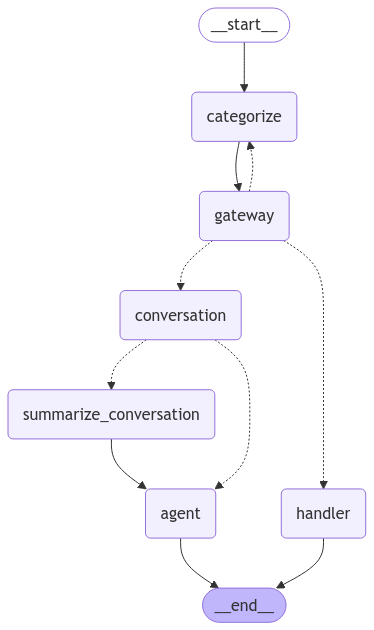

In [121]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [126]:
config = {"configurable": {"thread_id": "2"}}

In [127]:
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

In [130]:
# input_message = HumanMessage(content="hi! I'm bob")
# input_message.pretty_print()
# for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    # print_update(event)

input_message = HumanMessage(content="What is the radius of the earth?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# input_message = HumanMessage(content="")
# input_message.pretty_print()
# for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
#     print_update(event)

# input_message = HumanMessage(content="I like to code in Javascript, now im learning langchain & langgraph")
# input_message.pretty_print()
# for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
#     print_update(event)

================================ Human Message =================================

What is the radius of the earth?
================================ System Message ================================

Message category: offtopic
================================ Human Message =================================

hi! I'm bob
================================ System Message ================================

Message category: greeting
================================== Ai Message ==================================

Hello there! I'm thrilled to meet you!

I'm your BPMN process modeling assistant, here to help you create stunning BPMN diagrams and model your business processes with ease. Whether you're a seasoned pro or just starting out, I'm here to guide you through the process (pun intended!).

With my assistance, you can:

Create clear and concise BPMN diagrams that visualize your business processes
Model complex workflows and identify areas for improvement
Collaborate with your team and stakeho

In [129]:
checkpoint_data = memory.get({"configurable": {"thread_id": "2"}})
if checkpoint_data and "channel_values" in checkpoint_data:
  print("\nChannel Values:")
  for key, value in checkpoint_data["channel_values"].items():
    if isinstance(value, list):
      print(f"\n{key}:")
      for item in value:
        item.pretty_print()
    else:
      print(f"\n{key}: {value}")


Channel Values:

messages:
================================ Human Message =================================

hi! I'm bob
================================ System Message ================================

Message category: greeting
================================== Ai Message ==================================

Hello there! I'm thrilled to meet you!

I'm your BPMN process modeling assistant, here to help you create stunning BPMN diagrams and model your business processes with ease. Whether you're a seasoned pro or just starting out, I'm here to guide you through the process (pun intended!).

With my assistance, you can:

Create clear and concise BPMN diagrams that visualize your business processes
Model complex workflows and identify areas for improvement
Collaborate with your team and stakeholders to refine your processes
Analyze and optimize your business operations for maximum efficiency

So, what's on your mind? Do you have a process you'd like to model or a diagram you'd like to c